# Find Classwise Accuracy

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#tf.enable_eager_execution()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(13)

import py3nvml
py3nvml.grab_gpus(1)

1

In [2]:
from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8515479656940471502
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6959250571990860960
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12214507097971540566
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:0e:00.0, compute capability: 3.7"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6883384565843261682
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
multi_step = True
num_predicted_steps = 10
model_path = "trained_models_acc/multistep/LSTM_v3.h5"
num_quakes = 7136

# Load the dataset

In [4]:
data_path = "../data/histStat_norm_acc"

x_val = np.load(os.path.join(data_path, "X_val_histnorm.npy"))
y_val = np.load(os.path.join(data_path, "y_val_unnorm.npy"))
richters = np.load(os.path.join(data_path, "richters_discrete.npy"))

# Load and run the model

In [5]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(128,
                            return_sequences=True,
                            input_shape=x_val.shape[-2:]))
model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'))
model.add(tf.keras.layers.LSTM(64, activation='relu'))
model.add(tf.keras.layers.Dense(150))

model.load_weights(model_path)

model.compile(optimizer='nadam', loss='mae', metrics=['mae', 'mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 128)           73728     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 64)            49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 150)               9750      
Total params: 165,910
Trainable params: 165,910
Non-trainable params: 0
_________________________________________________________________


In [6]:
y_pred_norm = model.predict(x_val, batch_size = 4096).reshape(-1, 10, 15)

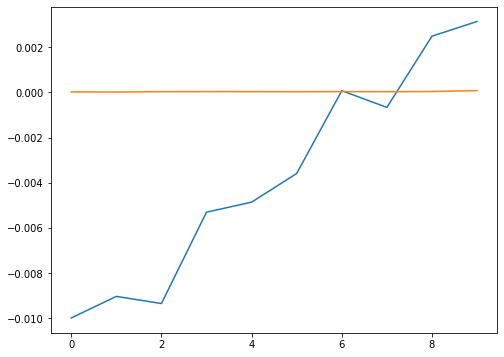

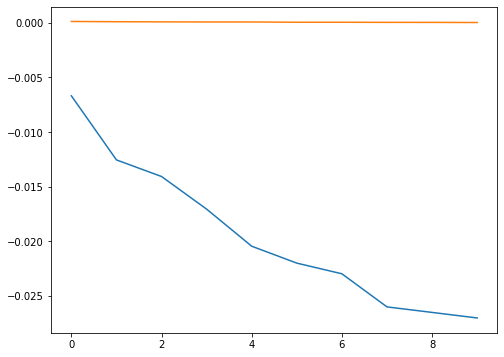

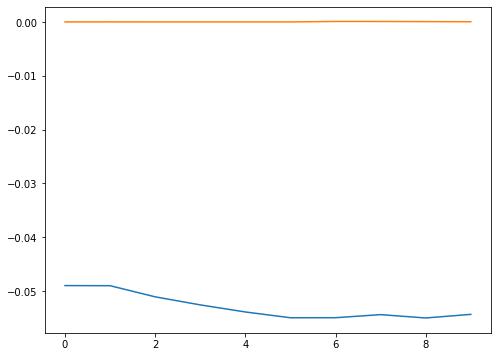

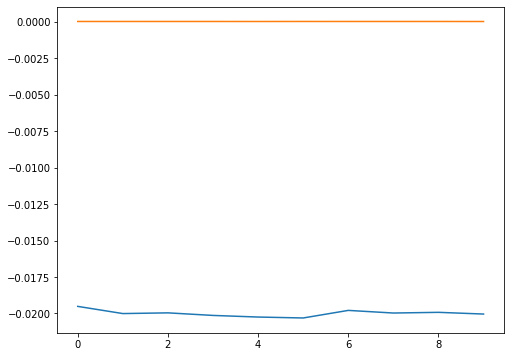

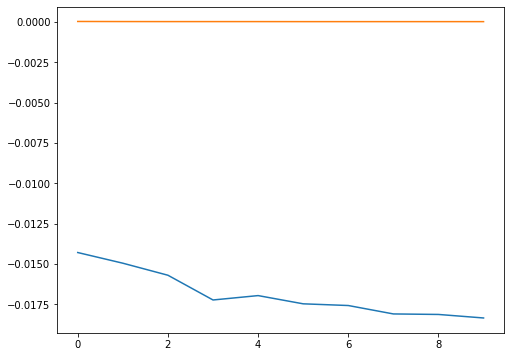

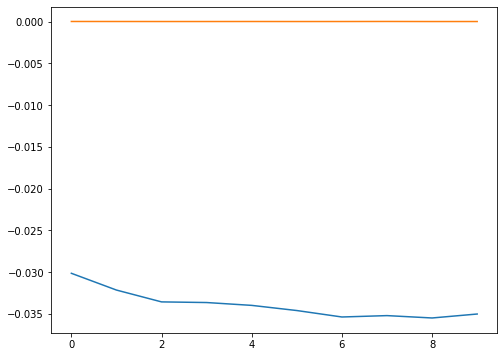

In [7]:
nums = [42, 114, 5636, 10234, 16352, 42295]
for num in nums:
    plt.figure()
    plt.plot(y_pred_norm[num, :, 0])
    plt.plot(y_val[num, :, 0])

# What if we just fit a scaling factor on the preds?

In [8]:
#Unnormalize the quake
val_mean = np.load(os.path.join(data_path, "mean_val_histnorm.npy"))
val_var = np.load(os.path.join(data_path, "var_val_histnorm.npy"))
print(val_mean.shape, val_var.shape)
y_pred = y_pred_norm*val_var + val_mean

(249760, 1, 1) (249760, 1, 1)


In [9]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression().fit(y_pred[:, -1, :].reshape(-1, 1), y_val[:, -1, :].flatten())

In [10]:
linreg.coef_, linreg.intercept_, linreg.score(y_pred[:, -1, :].reshape(-1, 1), y_val[:, -1, :].flatten())

(array([1.22522835]), 7.221870607072102e-05, 0.2438600706968762)

In [11]:
linreg_preds = linreg.predict(y_pred[:, -1, :].reshape(-1, 1)).reshape(-1, 15)
linreg_preds.shape

(249760, 15)

In [12]:
#MMI accel cutoffs (m/s^2) 
#              I,  II/III  IV        V      VI      VII       VIII      IX    X+
MMI_cutoffs = [    0.01667, 0.13729, 0.38246, 0.90221, 1.76520, 3.33426, 6.37432, 12.16025]
MMI_val = np.searchsorted(MMI_cutoffs, y_val[:, -1, :].reshape(-1), side = 'right')
MMI_pred = np.searchsorted(MMI_cutoffs, linreg_preds.reshape(-1), side = 'right')
print(y_val.shape, linreg_preds.shape, MMI_val.shape, MMI_pred.shape)

(249760, 10, 15) (249760, 15) (3746400,) (3746400,)


In [13]:
np.unique(MMI_val, return_counts = True), np.unique(MMI_pred, return_counts = True)

((array([0, 1, 2, 3, 4, 5]),
  array([3741532,    4218,     424,     192,      27,       7])),
 (array([0, 1, 2, 3]), array([3743773,    2196,     375,      56])))

In [14]:
# Ok that's no bueno. New idea - add the means as a second feature.
if val_mean.shape[-1] == 1:
    val_mean = np.repeat(val_mean, 15, axis=-1)
X = np.vstack((y_pred[:, -1, :].flatten(), val_mean.flatten())).T

In [15]:
linreg = LinearRegression().fit(X, y_val[:, -1, :].flatten())
print(linreg.coef_, linreg.intercept_, linreg.score(X, y_val[:, -1, :].flatten()))
linreg_preds = linreg.predict(X).reshape(-1, 15)
linreg_preds.shape

[ 1.75505672 -0.39594017] 9.29270472392165e-05 0.2676472907846814


(249760, 15)

In [16]:
#MMI accel cutoffs (m/s^2) 
#              I,  II/III  IV        V      VI      VII       VIII      IX    X+
MMI_cutoffs = [    0.01667, 0.13729, 0.38246, 0.90221, 1.76520, 3.33426, 6.37432, 12.16025]
MMI_val = np.searchsorted(MMI_cutoffs, y_val[:, -1, :].reshape(-1), side = 'right')
MMI_pred = np.searchsorted(MMI_cutoffs, linreg_preds.reshape(-1), side = 'right')
print(y_val.shape, linreg_preds.shape, MMI_val.shape, MMI_pred.shape)
np.unique(MMI_val, return_counts = True), np.unique(MMI_pred, return_counts = True)

(249760, 10, 15) (249760, 15) (3746400,) (3746400,)


((array([0, 1, 2, 3, 4, 5]),
  array([3741532,    4218,     424,     192,      27,       7])),
 (array([0, 1, 2, 3, 4]),
  array([3743535,    2446,     354,      64,       1])))

[0, 1, 2, 3, 4, 5]


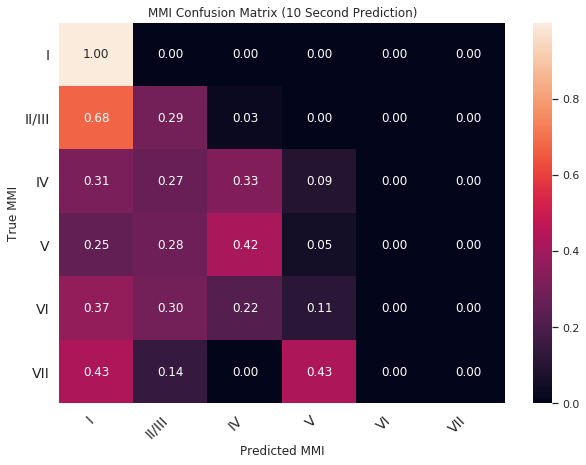

In [17]:
def print_confusion_matrix(confusion_matrix, class_names = None, figsize = (10,7), fontsize=14, labels=None, title=None):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    sns.set(font_scale=1)
    if class_names == None:
        class_names = list(np.arange(len(confusion_matrix)))
        
    print(class_names)
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')
    
    if labels:
        heatmap.yaxis.set_ticklabels(labels, rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(labels, rotation=45, ha='right', fontsize=fontsize)
    else:
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True MMI')
    plt.xlabel('Predicted MMI')
    if title != None:
        plt.title(title)
    return fig
from sklearn import metrics
cmat = metrics.confusion_matrix(MMI_val, MMI_pred)
cmat = cmat / np.expand_dims(np.sum(cmat, axis = 1), 1)
print_confusion_matrix(cmat, labels=["I", "II/III", "IV", "V", "VI", "VII", "VIII", "IX", "X+"], title="MMI Confusion Matrix (10 Second Prediction)");

## What about the max pred over each quake?

In [18]:
max_linreg_preds = np.max(linreg_preds.reshape(num_quakes, -1, 15), axis = 1)
max_y_val =  np.max(y_val[:, -1, :].reshape(num_quakes, -1, 15), axis = 1)

[0, 1, 2, 3, 4, 5]


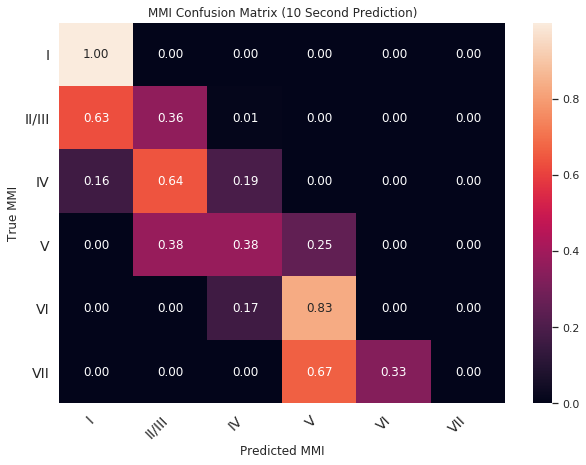

In [19]:
MMI_val = np.searchsorted(MMI_cutoffs, max_y_val.reshape(-1), side = 'right')
MMI_pred = np.searchsorted(MMI_cutoffs, max_linreg_preds.reshape(-1), side = 'right')
cmat = metrics.confusion_matrix(MMI_val, MMI_pred)
cmat = cmat / np.expand_dims(np.sum(cmat, axis = 1), 1)
print_confusion_matrix(cmat, labels=["I", "II/III", "IV", "V", "VI", "VII", "VIII", "IX", "X+"], title="MMI Confusion Matrix (10 Second Prediction)");

In [20]:
argmax_linreg_preds = np.argmax(linreg_preds.reshape(num_quakes, -1, 15), axis = 1)
argmax_y_val =  np.argmax(y_val[:, -1, :].reshape(num_quakes, -1, 15), axis = 1)

<BarContainer object of 69 artists>

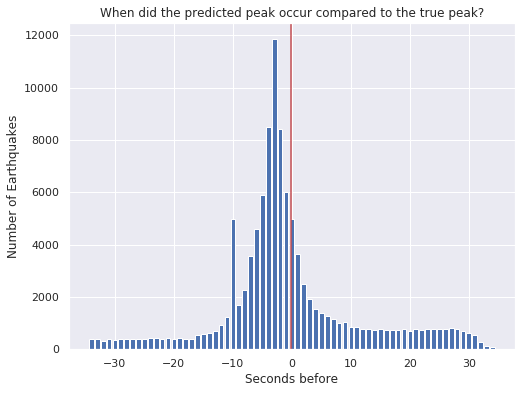

In [21]:
diffs, freq = np.unique(argmax_y_val.flatten() - argmax_linreg_preds.flatten(), return_counts = True)
plt.figure()
plt.title("When did the predicted peak occur compared to the true peak?")
plt.ylabel("Number of Earthquakes")
plt.xlabel("Seconds before")
plt.gca().axvline(-0.1, color='r')
plt.bar(diffs, freq)

In [22]:
diffs[33:], freq[33:]

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34]),
 array([6003, 4997, 3630, 2491, 1917, 1531, 1378, 1258, 1154, 1017, 1044,
         863,  844,  788,  774,  751,  775,  726,  749,  733,  775,  708,
         793,  738,  758,  790,  773,  786,  817,  760,  708,  607,  539,
         271,  123,   94]))

## Let's plot some "before" predictions

In [79]:
max_y_val =  np.max(y_val[:, -1, :].reshape(num_quakes, -1, 15), axis = 1)
argmax_y_val = np.argmax(y_val[:, -1, :].reshape(num_quakes, -1, 15), axis = 1)
max_y_val.shape, argmax_y_val.shape

((7136, 15), (7136, 15))

In [80]:
model_preds = linreg_preds.reshape(num_quakes, -1, 15)

def get_preds_before(max_y_val, argmax_y_val, model_preds, offset = 0):
    #Take max over predictions before the max of the real quake
    max_linreg_preds = np.zeros_like(max_y_val)
    for i in range(max_y_val.shape[0]):
        for j in range(max_y_val.shape[1]):
            window_limit = argmax_y_val[i][j] - offset + 1
            if window_limit <= 0:
                #Well, we can't predict 5 seconds before the first second, can we?
                max_linreg_preds[i][j] = 0
            else:
                max_linreg_preds[i][j] = np.max(model_preds[i, :argmax_y_val[i][j] - offset + 1, j])
    return max_linreg_preds
max_linreg_preds = get_preds_before(max_y_val, argmax_y_val, model_preds, offset = 0)

[0, 1, 2, 3, 4, 5]


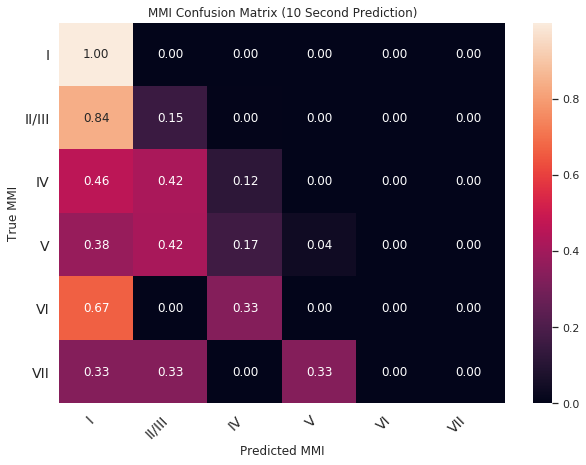

In [81]:
MMI_val = np.searchsorted(MMI_cutoffs, max_y_val.reshape(-1), side = 'right')
MMI_pred = np.searchsorted(MMI_cutoffs, max_linreg_preds.reshape(-1), side = 'right')
cmat = metrics.confusion_matrix(MMI_val, MMI_pred)
cmat = cmat / np.expand_dims(np.sum(cmat, axis = 1), 1)
print_confusion_matrix(cmat, labels=["I", "II/III", "IV", "V", "VI", "VII", "VIII", "IX", "X+"], title="MMI Confusion Matrix (10 Second Prediction)");

In [82]:
alert_thresh = 3  #MMI V
fpr = np.mean(MMI_pred[MMI_val < alert_thresh] >= alert_thresh)
fnr = np.mean(MMI_pred[MMI_val >= alert_thresh] < alert_thresh)
fpr, fnr

(0.0, 0.9393939393939394)

In [83]:
# Make a F1 Curve
decision_threshes = np.linspace(0, 1, 1001)
alert_thresh = 0.38246
y_true = max_y_val.flatten()
y_pred = max_linreg_preds.flatten()
sens = []
spec = []
for decision_thresh in decision_threshes:
    sens.append(np.mean(y_pred[y_true >= alert_thresh] >= decision_thresh))
    spec.append(np.mean(y_pred[y_true < alert_thresh] < decision_thresh))
    
sens = np.array(sens)
spec = np.array(spec)
sens, spec

(array([1.        , 0.75757576, 0.72727273, ..., 0.        , 0.        ,
        0.        ]),
 array([0.00220546, 0.96516116, 0.98407581, ..., 1.        , 1.        ,
        1.        ]))

0.8711963335165556


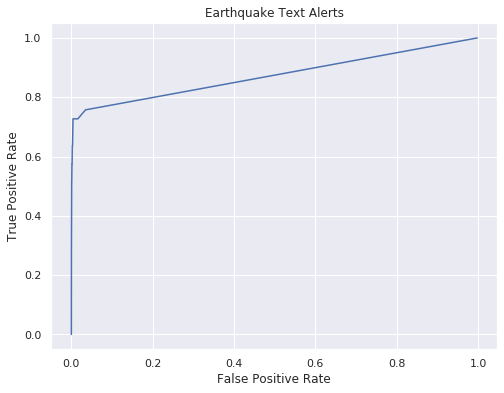

In [84]:
plt.title("Earthquake Text Alerts")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.plot(1-spec, sens)

print(sklearn.metrics.auc(1-spec, sens))

In [91]:
molchan_tau = []
molchan_tpr = []
for offset in time_offsets:
    curr_tau = []
    curr_tpr = []
    
    max_y_val =  np.max(y_val[:, offset, :].reshape(num_quakes, -1, 15), axis = 1)
    argmax_y_val = np.argmax(y_val[:, offset, :].reshape(num_quakes, -1, 15), axis = 1)
    X = np.vstack((y_pred[:, offset, :].flatten(), val_mean.flatten())).T
    model_preds = linreg.predict(X).reshape(num_quakes, -1, 15)
    max_linreg_preds = get_preds_before(max_y_val, argmax_y_val, model_preds, offset = 0)
    
    curr_MMI = np.searchsorted(MMI_cutoffs, max_y_val.reshape(-1), side = 'right')

    for margin in margins:
        curr_MMI_pred = np.searchsorted(MMI_cutoffs, max_linreg_preds.reshape(-1) + margin, side = 'right')
        sens = np.mean(curr_MMI_pred[curr_MMI >= alert_thresh] >= alert_thresh)
        tau = np.mean(curr_MMI_pred >= alert_thresh)
        curr_tpr.append(sens)
        curr_tau.append(tau)
        
    molchan_tau.append(curr_tau)
    molchan_tpr.append(curr_tpr)
molchan_tau = np.array(molchan_tau)
molchan_tpr = np.array(molchan_tpr)
molchan_tau = np.concatenate((np.zeros((10, 1)), molchan_tau), axis = 1)
molchan_tpr = np.concatenate((np.zeros((10, 1)), molchan_tpr), axis = 1)
molchan_tau, molchan_tpr

IndexError: too many indices for array

# Recover the original quakes

In [8]:
#Unnormalize the quake
val_mean = np.load(os.path.join(data_path, "mean_val_histnorm.npy"))
val_var = np.load(os.path.join(data_path, "var_val_histnorm.npy"))
print(val_mean.shape, val_var.shape)
y_pred = y_pred_norm*val_var + val_mean

(249760, 1, 15) (249760, 1, 15)


(array([1.0083000e+04, 2.6116278e+07, 8.0627180e+06, 2.0689550e+06,
        8.7123200e+05, 2.9044500e+05, 4.0615000e+04, 3.5520000e+03,
        1.1900000e+02, 3.0000000e+00]),
 array([-0.22324914, -0.11320124, -0.00315334,  0.10689457,  0.21694246,
         0.32699037,  0.43703827,  0.5470862 ,  0.65713406,  0.767182  ,
         0.87722987], dtype=float32),
 <a list of 10 Patch objects>)

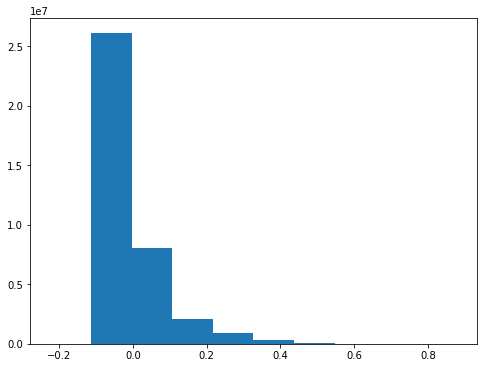

In [17]:
plt.hist(y_pred_norm.flatten())

(array([3.744313e+07, 1.594700e+04, 3.117000e+03, 9.920000e+02,
        4.640000e+02, 1.510000e+02, 1.410000e+02, 3.900000e+01,
        1.500000e+01, 4.000000e+00]),
 array([-0.13184544,  0.05584651,  0.24353847,  0.43123043,  0.61892239,
         0.80661435,  0.9943063 ,  1.18199826,  1.36969022,  1.55738218,
         1.74507414]),
 <a list of 10 Patch objects>)

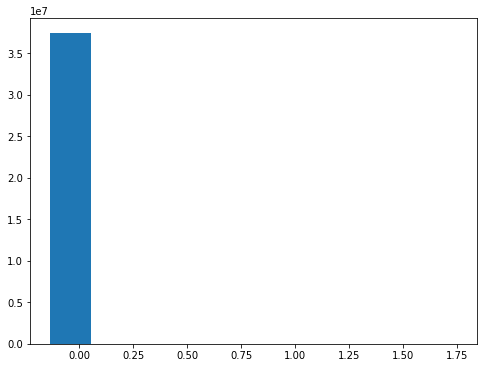

In [18]:
plt.hist(y_pred.flatten())

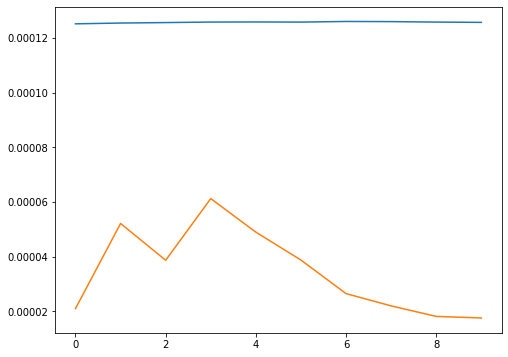

In [13]:
plt.plot(y_pred[2, :, 0]*10)
plt.plot(y_val[2, :, 0])

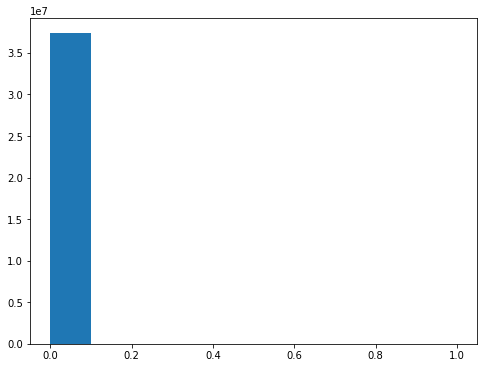

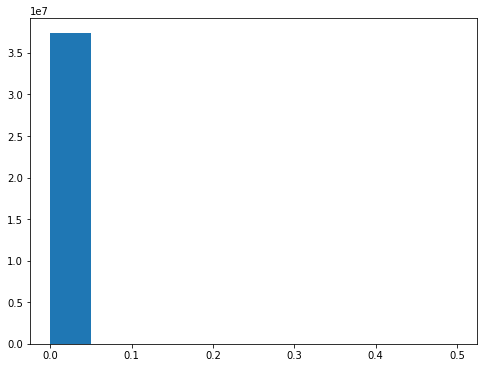

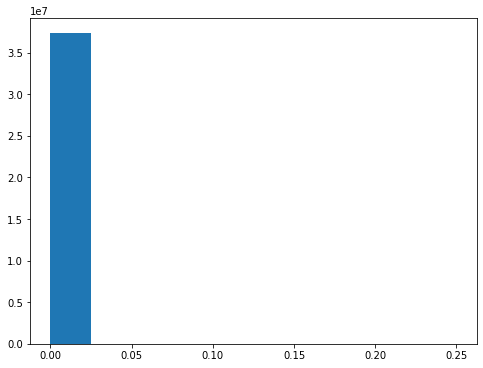

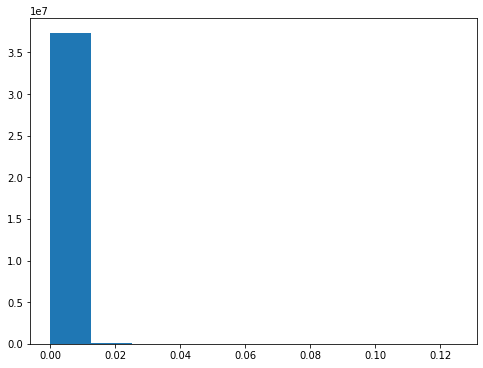

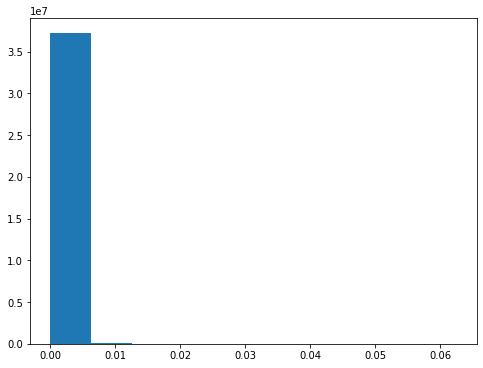

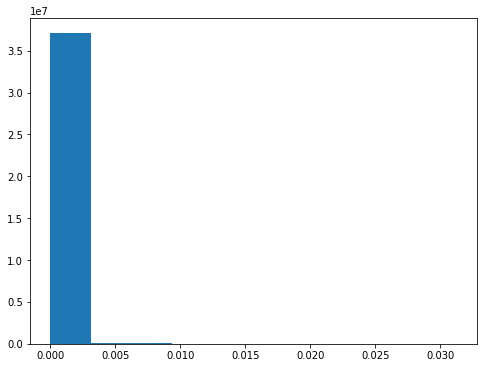

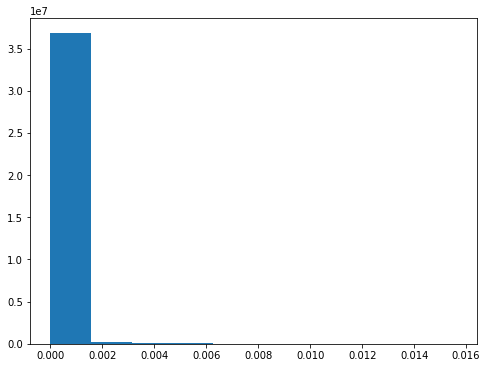

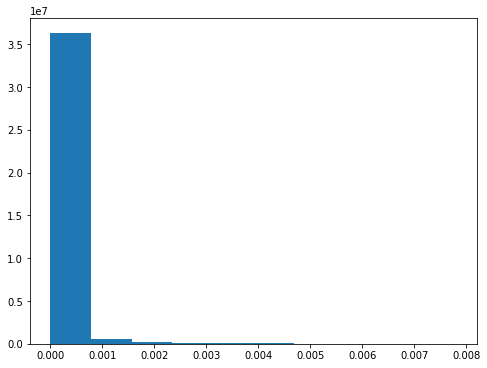

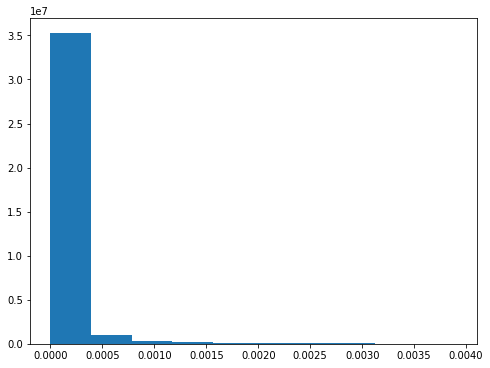

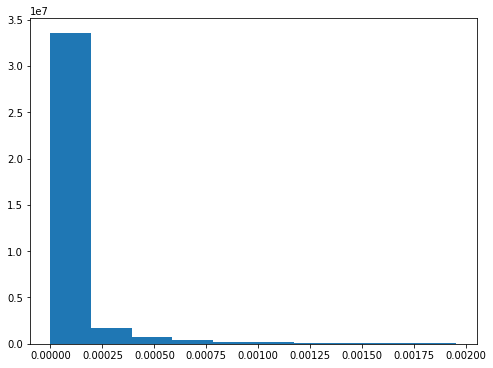

In [15]:
for i in range(10):
    thresh = 1/(2**i)
    plt.figure()
    plt.hist(y_pred.flatten()[np.logical_and(y_pred.flatten() < thresh, y_pred.flatten() >= 0)])

In [33]:
y_pred.mean(), y_pred_norm.mean(), val_mean.mean()

(0.00019789368039167248, -0.0030214526, 0.00022241172102910848)

In [34]:
np.sum(y_pred < 0)/np.prod(y_pred.shape)

0.0019532084134102072

In [35]:
#Take the last prediction in a multistep model
y_pred = y_pred[:, -1, :]
#y_pred = y_pred[:, 0, :] # Or the first one, for 1 second preds
y_true = y_val[:, -1, :]
    
y_pred.shape, y_true.shape

((249760, 15), (249760, 15))

In [37]:
#Recover the original quakes (before windowing)
y_pred = y_pred.reshape((num_quakes, -1, 15))
y_true = y_true.reshape((num_quakes, -1, 15))
y_pred.shape, y_true.shape

((7136, 35, 15), (7136, 35, 15))

In [38]:
def mae(delta):
    return np.mean(np.abs(delta))
mae(y_true - y_pred)

0.22787903908346052

In [39]:
from sklearn import metrics

y_true_flat = y_true.reshape(-1)
y_pred_flat = y_pred.reshape(-1)
print("Explained Variance Score:", metrics.explained_variance_score(y_true_flat, y_pred_flat)) 
print("Max Error Score:", metrics.max_error(y_true_flat, y_pred_flat)) 
print("Mean Absolute Error Score:", metrics.mean_absolute_error(y_true_flat, y_pred_flat)) 
print("Mean Squared Error Score:", metrics.mean_squared_error(y_true_flat, y_pred_flat)) 
print("Median Absolute Error Score:", metrics.median_absolute_error(y_true_flat, y_pred_flat)) 
print("R2 Score:", metrics.r2_score(y_true_flat, y_pred_flat)) 

Explained Variance Score: 0.0004965571750463749
Max Error Score: 2631.373380175103
Mean Absolute Error Score: 0.22787903908346052
Mean Squared Error Score: 44.859996169683775
Median Absolute Error Score: 0.022921190114353146
R2 Score: -0.0006611797061832903


# Alert accuracy

In [19]:
#MMI accel cutoffs (m/s^2) 
#              I,  II/III  IV        V      VI      VII       VIII      IX    X+
MMI_cutoffs = [    0.01667, 0.13729, 0.38246, 0.90221, 1.76520, 3.33426, 6.37432, 12.16025]

In [48]:
MMI_val = np.searchsorted(MMI_cutoffs, y_true.reshape(-1), side = 'right')
MMI_pred = np.searchsorted(MMI_cutoffs, y_pred.reshape(-1), side = 'right')
print(y_true.shape, y_pred.shape, MMI_val.shape, MMI_pred.shape)

(7136, 35, 15) (7136, 35, 15) (3746400,) (3746400,)


In [49]:
np.unique(MMI_val, return_counts = True), np.unique(MMI_pred, return_counts = True)

((array([0, 1, 2, 3, 4, 5]),
  array([3741532,    4218,     424,     192,      27,       7])),
 (array([0, 1, 2, 3, 4]),
  array([3740911,    4755,     548,     166,      20])))

[0, 1, 2, 3, 4, 5]


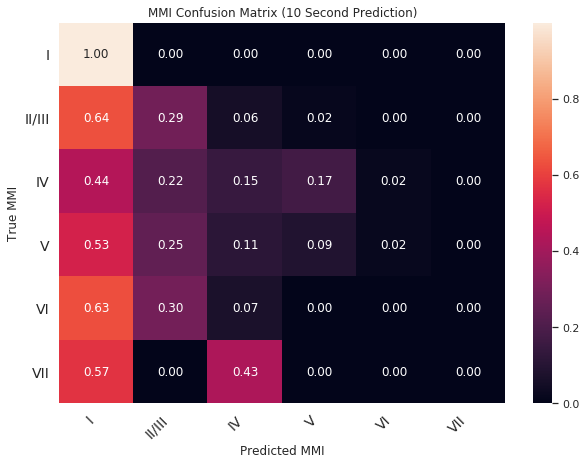

In [50]:
def print_confusion_matrix(confusion_matrix, class_names = None, figsize = (10,7), fontsize=14, labels=None, title=None):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    sns.set(font_scale=1)
    if class_names == None:
        class_names = list(np.arange(len(confusion_matrix)))
        
    print(class_names)
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')
    
    if labels:
        heatmap.yaxis.set_ticklabels(labels, rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(labels, rotation=45, ha='right', fontsize=fontsize)
    else:
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True MMI')
    plt.xlabel('Predicted MMI')
    if title != None:
        plt.title(title)
    return fig

cmat = metrics.confusion_matrix(MMI_val, MMI_pred)
cmat = cmat / np.expand_dims(np.sum(cmat, axis = 1), 1)
print_confusion_matrix(cmat, labels=["I", "II/III", "IV", "V", "VI", "VII", "VIII", "IX", "X+"], title="MMI Confusion Matrix (10 Second Prediction)");

In [54]:
alert_thresh = 3  #MMI V
fpr = np.mean(MMI_pred[MMI_val < alert_thresh] >= alert_thresh)
fnr = np.mean(MMI_pred[MMI_val >= alert_thresh] < alert_thresh)
fpr, fnr

(3.7372699243202844e-05, 0.0)

In [55]:
# Make a F1 Curve
decision_threshes = np.linspace(0, 0.01, 1001)
alert_thresh = 0.38246
sens = []
spec = []
for decision_thresh in decision_threshes:
    sens.append(np.mean(y_pred.reshape(-1)[y_true.reshape(-1) >= alert_thresh] >= decision_thresh))
    spec.append(np.mean(y_pred.reshape(-1)[y_true.reshape(-1) < alert_thresh] < decision_thresh))
    
sens = np.array(sens)
spec = np.array(spec)
sens, spec

NameError: name 'y_true' is not defined

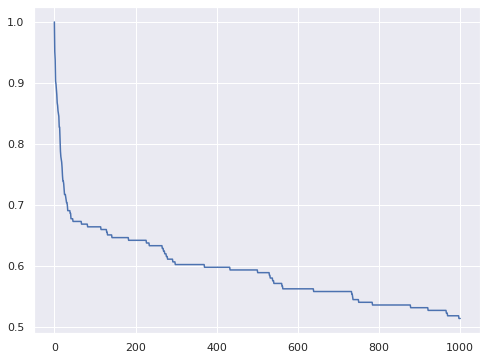

In [55]:
plt.plot(sens)

0.8922854416596492


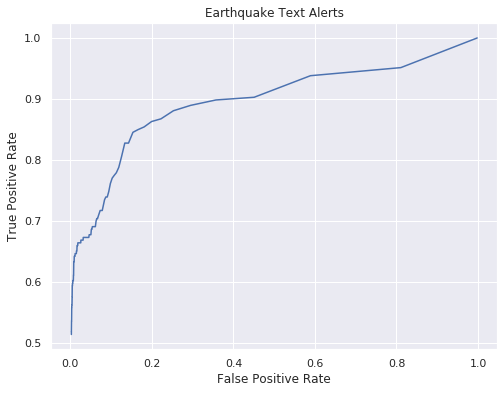

In [56]:
plt.title("Earthquake Text Alerts")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.plot(1-spec, sens)

print(sklearn.metrics.auc(1-spec, sens))

EER:  0.8465183411128261 0.8451327433628318


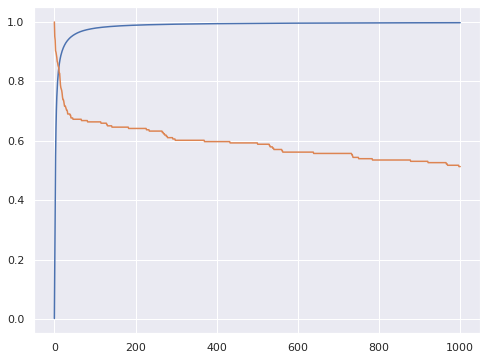

In [57]:
#Find EER
temp = spec > sens
print("EER: ", spec[np.argmax(temp)], sens[np.argmax(temp)])
plt.plot(spec)
plt.plot(sens)

# Molchan time!
We will draw Molchan curves, one line for every time offset, with the line parameterized by additional margin

/home/danjwu/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/danjwu/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/danjwu/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/danjwu/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/danjwu/anaconda3/lib/pytho

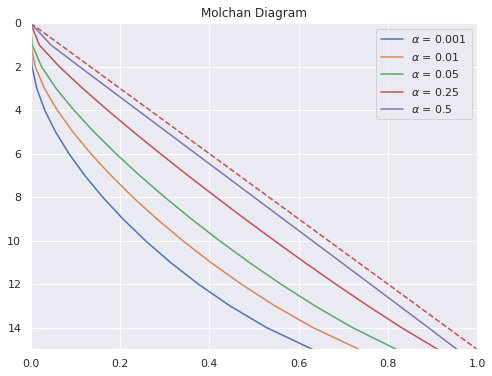

In [63]:
#python version of above equation
from scipy.special import comb
from scipy.optimize import fsolve

def func(a, N, h, tau):
    out = 0
    for i in range(h, N+1):
        out += comb(N, i) * (tau**i) * (1-tau)**(N-i)
        
    return out - a

#Solves for one tau
def get_tau(a, N, h):
    sfunc = lambda tau : func(a, N, h, tau)
    
    x = np.arange(0, 1, 0.01)
    y = np.array([sfunc(datum) for datum in x])
    init_guess = np.argmax(y > 0)/100
    
    return fsolve(sfunc, init_guess)

#Gives all the taus
def get_taus(a, N, h):
    taus = np.zeros(h.shape)
    
    for i in range(len(h)):
        taus[i] = get_tau(a, N, i)
        
    return taus
        
#Plots a molchan
def plot_molchan(N):
    h = np.arange(N+1)
    
    plt.figure()
    plt.plot(np.linspace(0, 1, 10), np.linspace(0, N, 10), 'r--')
    for a in [0.001, 0.01, 0.05, 0.25, 0.50]:
        plt.plot(get_taus(a, N, h), h, label=r'$\alpha$ = ' + str(a))
    plt.xlim([0, 1])
    plt.ylim([N, 0])
    plt.legend()
    plt.title("Molchan Diagram")
    plt.show()
    
plot_molchan(15)

In [64]:
time_offsets = np.arange(10)
margins = np.linspace(0.01, 0.02, 101)
time_offsets, margins

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0.01  , 0.0101, 0.0102, 0.0103, 0.0104, 0.0105, 0.0106, 0.0107,
        0.0108, 0.0109, 0.011 , 0.0111, 0.0112, 0.0113, 0.0114, 0.0115,
        0.0116, 0.0117, 0.0118, 0.0119, 0.012 , 0.0121, 0.0122, 0.0123,
        0.0124, 0.0125, 0.0126, 0.0127, 0.0128, 0.0129, 0.013 , 0.0131,
        0.0132, 0.0133, 0.0134, 0.0135, 0.0136, 0.0137, 0.0138, 0.0139,
        0.014 , 0.0141, 0.0142, 0.0143, 0.0144, 0.0145, 0.0146, 0.0147,
        0.0148, 0.0149, 0.015 , 0.0151, 0.0152, 0.0153, 0.0154, 0.0155,
        0.0156, 0.0157, 0.0158, 0.0159, 0.016 , 0.0161, 0.0162, 0.0163,
        0.0164, 0.0165, 0.0166, 0.0167, 0.0168, 0.0169, 0.017 , 0.0171,
        0.0172, 0.0173, 0.0174, 0.0175, 0.0176, 0.0177, 0.0178, 0.0179,
        0.018 , 0.0181, 0.0182, 0.0183, 0.0184, 0.0185, 0.0186, 0.0187,
        0.0188, 0.0189, 0.019 , 0.0191, 0.0192, 0.0193, 0.0194, 0.0195,
        0.0196, 0.0197, 0.0198, 0.0199, 0.02  ]))

In [89]:
y_pred_norm = model.predict(x_val, batch_size = 4096).reshape(-1, 10, 15)
#Unnormalize the quake
val_mean = np.load(os.path.join(data_path, "mean_val_histnorm.npy"))
val_var = np.load(os.path.join(data_path, "var_val_histnorm.npy"))
print(val_mean.shape, val_var.shape)
y_pred = y_pred_norm*val_var + val_mean

(249760, 1, 15) (249760, 1, 15)


In [90]:
y_pred.shape, y_val.shape

((249760, 10, 15), (249760, 10, 15))

In [91]:
molchan_tau = []
molchan_tpr = []
for offset in time_offsets:
    curr_tau = []
    curr_tpr = []
    
    curr_y = y_val[:, offset, :].reshape(num_quakes, -1, 15)
    curr_y_pred = y_pred[:, offset, :].reshape(num_quakes, -1, 15)
    
    curr_MMI = np.searchsorted(MMI_cutoffs, curr_y.reshape(-1), side = 'right')

    for margin in margins:
        curr_MMI_pred = np.searchsorted(MMI_cutoffs, curr_y_pred.reshape(-1) + margin, side = 'right')
        sens = np.mean(curr_MMI_pred[curr_MMI >= alert_thresh] >= alert_thresh)
        tau = np.mean(curr_MMI_pred >= alert_thresh)
        curr_tpr.append(sens)
        curr_tau.append(tau)
        
    molchan_tau.append(curr_tau)
    molchan_tpr.append(curr_tpr)
molchan_tau = np.array(molchan_tau)
molchan_tpr = np.array(molchan_tpr)
molchan_tau = np.concatenate((np.zeros((10, 1)), molchan_tau), axis = 1)
molchan_tpr = np.concatenate((np.zeros((10, 1)), molchan_tpr), axis = 1)
molchan_tau, molchan_tpr

(array([[0.        , 0.00457773, 0.00463859, ..., 0.99809951, 0.99810058,
         0.99810191],
        [0.        , 0.00438261, 0.00444533, ..., 0.99807789, 0.99807816,
         0.99807896],
        [0.        , 0.00421418, 0.00427771, ..., 0.99807469, 0.99807522,
         0.99807709],
        ...,
        [0.        , 0.00381673, 0.00386318, ..., 0.99808136, 0.99808216,
         0.99808216],
        [0.        , 0.00372117, 0.00377536, ..., 0.99803171, 0.99803358,
         0.99803385],
        [0.        , 0.0036072 , 0.00365524, ..., 0.99795377, 0.99795377,
         0.99795457]]),
 array([[0.        , 0.00668665, 0.00678709, ..., 0.99994489, 0.99994489,
         0.99994489],
        [0.        , 0.00639851, 0.00650179, ..., 0.99988519, 0.99988519,
         0.99988519],
        [0.        , 0.0061067 , 0.00621067, ..., 0.99985046, 0.99985046,
         0.99985046],
        ...,
        [0.        , 0.00556016, 0.00563741, ..., 0.99975332, 0.99975332,
         0.99975332],
        [0. 

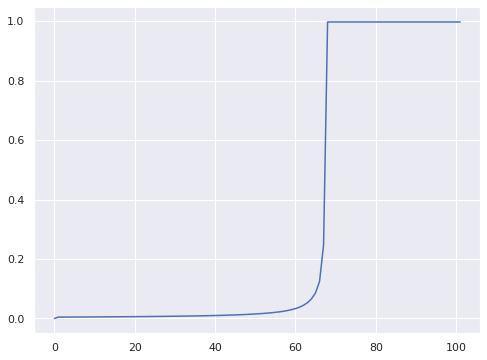

In [92]:
plt.plot(molchan_tau[0])

(0, 1)

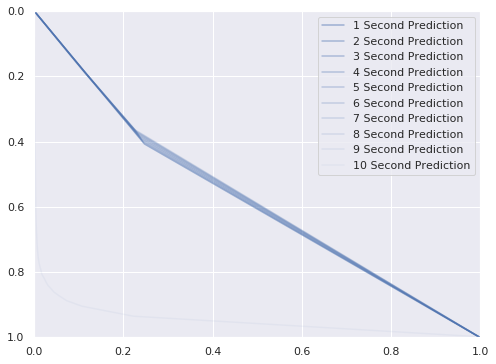

In [93]:
for i in time_offsets:
    plt.plot(molchan_tau[i], molchan_tpr[i], color = 'b', alpha = 0.5 - 0.05*i, label = str(i+1) + " Second Prediction")
plt.legend()
plt.ylim([1, 0])
plt.xlim([0, 1])

/home/danjwu/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/danjwu/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/danjwu/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


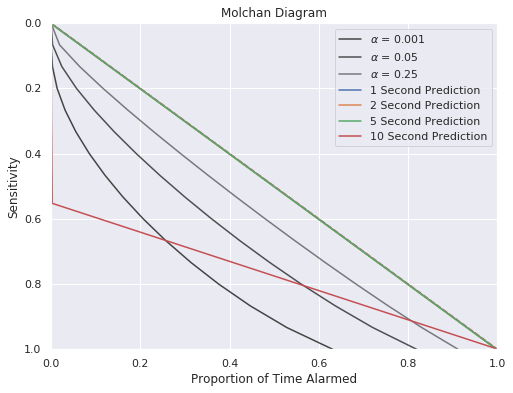

In [73]:
#Plots a result molchan
def plot_molchan_result(tau, tpr, time_offsets, N = 15):
    h = np.arange(N+1)
    
    plt.figure()
    
    #Plot significance thresholds
    plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), 'r--')
    for a in [0.001, 0.05, 0.25]:
        plt.plot(get_taus(a, N, h), h/N, color = 'k', alpha = 0.8 - a, label=r'$\alpha$ = ' + str(a))
        
    for i in range(len(time_offsets)):
        plt.plot(tau[i], tpr[i], color = 'C' + str(i), label = str(time_offsets[i]+1) + " Second Prediction")
        
    plt.xlim([0, 1])
    plt.ylim([1, 0])
    plt.ylabel("Sensitivity")
    plt.xlabel("Proportion of Time Alarmed")
    plt.legend()
    plt.title("Molchan Diagram")
    plt.show()
    
idxs = [0, 1, 4, 9]
plot_molchan_result(molchan_tau[idxs], molchan_tpr[idxs], time_offsets[idxs])

# Alert Latency

In [45]:
# Find the time from origin it takes for the model to predict
large_quake_idxs = np.nonzero(np.max(np.max(og_y, axis = -1), axis=-1) > MMI_cutoffs[1])
large_quakes = og_y[large_quake_idxs]
large_quakes_pred = og_y_pred[large_quake_idxs]
large_quake_idxs

(array([ 193,  299,  353,  444,  840,  936,  981, 1130, 1757, 2033, 2880,
        2976, 3003, 3703, 4027, 4075, 5132, 5385, 5810, 5921, 6165, 6250,
        6305, 6310, 6445, 6683]),)

Quake 0


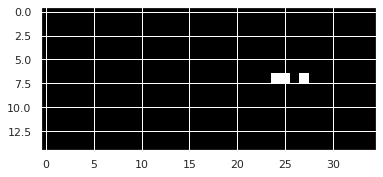

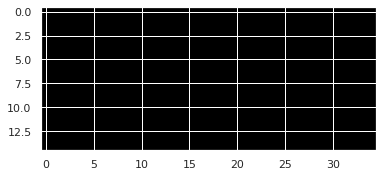

Quake 1


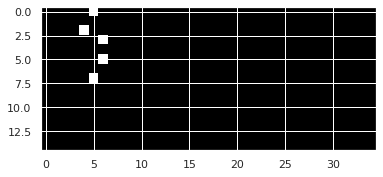

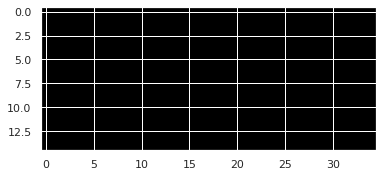

Quake 2


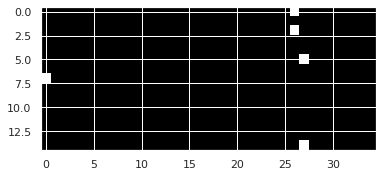

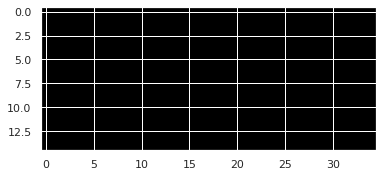

Quake 3


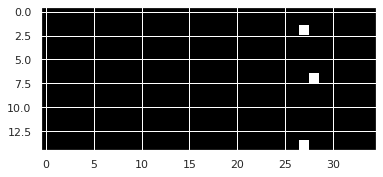

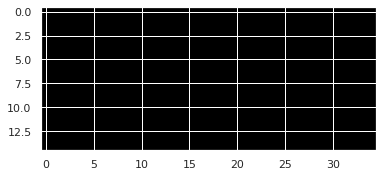

Quake 4


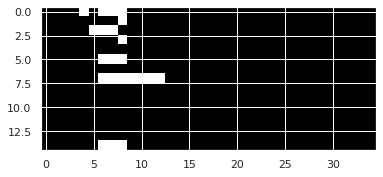

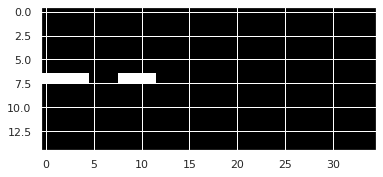

Quake 5


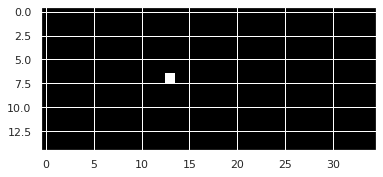

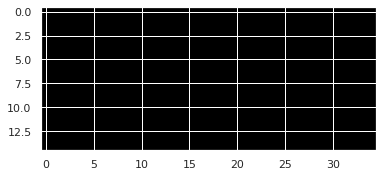

Quake 6


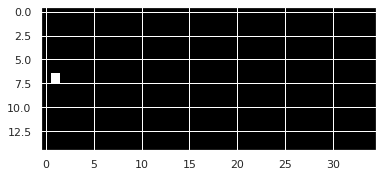

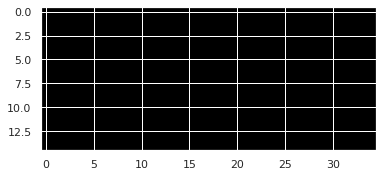

Quake 7


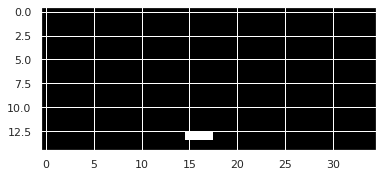

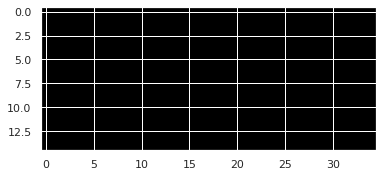

Quake 8


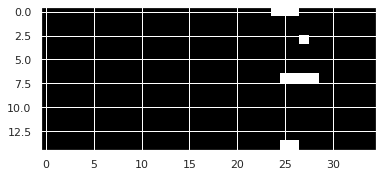

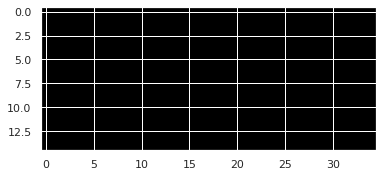

Quake 9


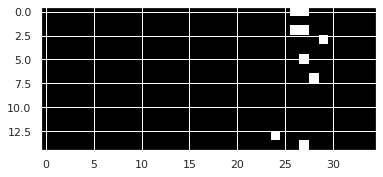

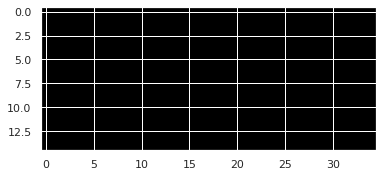

Quake 10


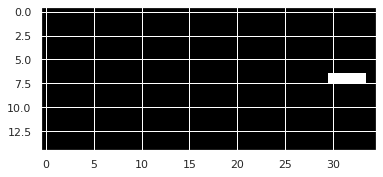

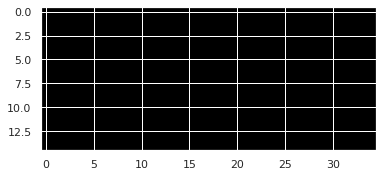

Quake 11


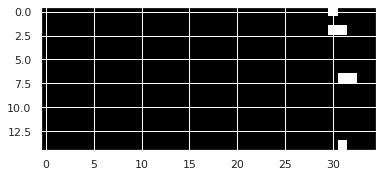

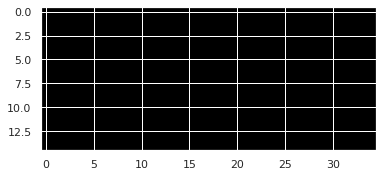

Quake 12


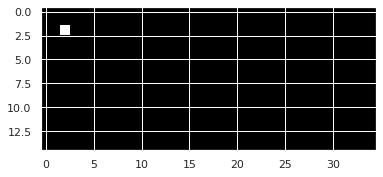

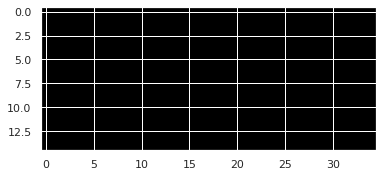

Quake 13


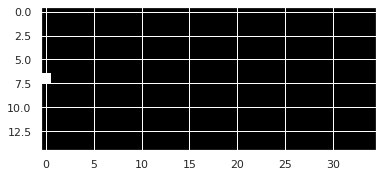

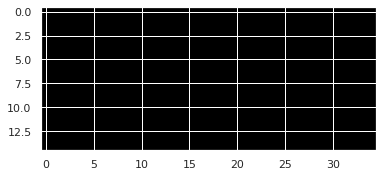

Quake 14


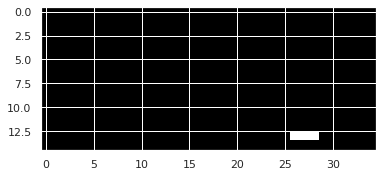

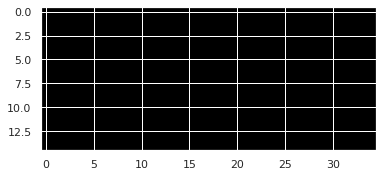

Quake 15


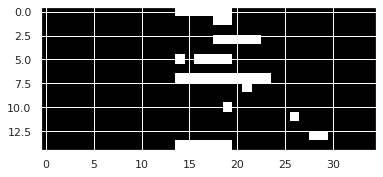

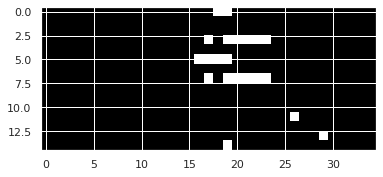

Quake 16


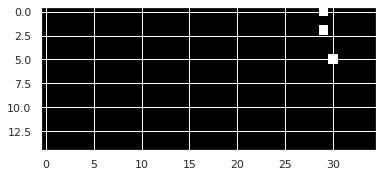

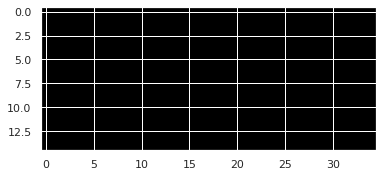

Quake 17


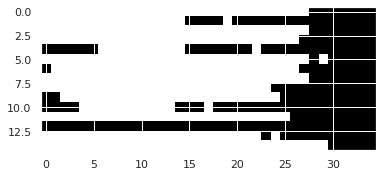

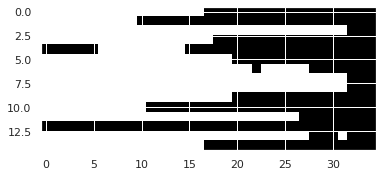

Quake 18


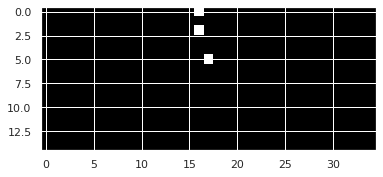

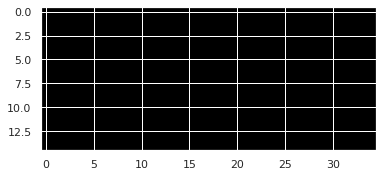

Quake 19


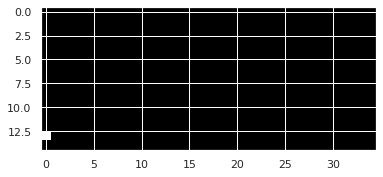

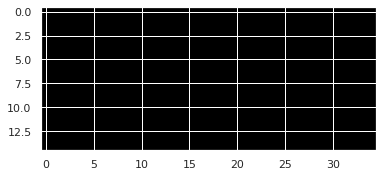

Quake 20


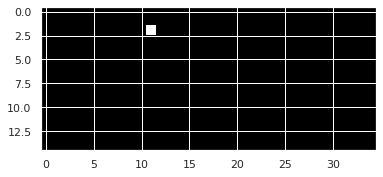

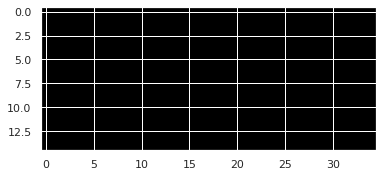

Quake 21


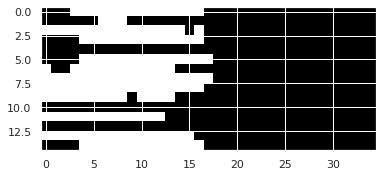

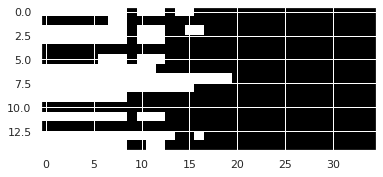

Quake 22


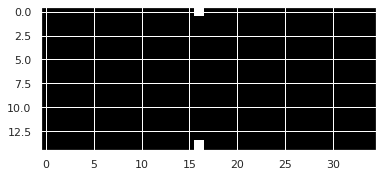

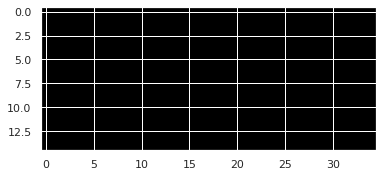

Quake 23


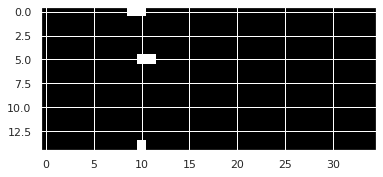

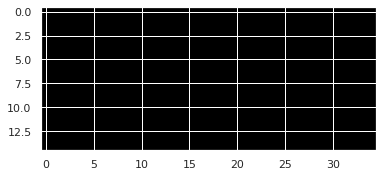

Quake 24


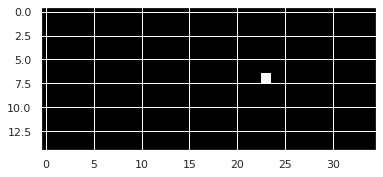

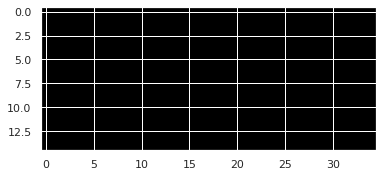

Quake 25


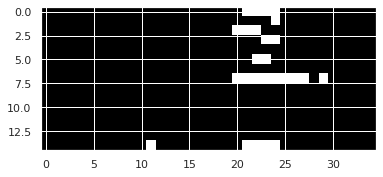

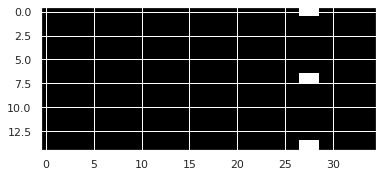

In [57]:
for i, quake, quake_pred in zip(range(len(large_quakes)), large_quakes, large_quakes_pred):
    print("Quake", i)
    plt.figure()
    plt.imshow(quake.T > MMI_cutoffs[1], interpolation='none', cmap='gray')
    plt.show()
    plt.figure()
    plt.imshow(quake_pred.T > MMI_cutoffs[1], interpolation='none', cmap='gray')
    plt.show()

# Peak Deviation

In [ ]:
deviation = np.abs(np.max(og_y, axis = (-1, -2)) - np.max(og_y_pred, axis=(-1, -2)))
plt.hist(deviation)